# Monkey Species Classification..

## <span style= "color:red;">Highlights of the Project:</span>
#### * We will be using Pre-Trained model.
#### * We will TUNE our Pre-Trained model.
#### * We will use tf.data to load and preprocess our images for finer control.
#### * We will use PERFORMANCE OPTIMIZATION TECHNIQUES for faster training.
#### * We will EVALUATE our model performance after training on totally unseen images by our model.

In [ ]:
## imports:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import os
import glob
import random
import pathlib
import zipfile

## <span style= "color:purple;">Part 1: Evaluating csv file which has info about our dataset:</span>

In [ ]:
## importing textfile having informattion about our dataset:

dataset_info = pd.read_csv("../input/10-monkey-species/monkey_labels.txt")

In [ ]:
dataset_info

In [ ]:
## let's see column names:

dataset_info.columns

In [ ]:
## let's have a look at label and common name:

dataset_info["Label"][0],dataset_info[' Common Name                   '][0]

In [ ]:
## we can see that their are lots unusual spaces,
## let's get rid of them because folders are names as n0, n1 .....
## we need to link these n0, n1 ... with common name which we will use as our class names...

In [ ]:
## using lambda function to remove white spaces:

dataset_info["Label"] = dataset_info["Label"].apply(lambda x: x.replace(" ",""))
dataset_info[' Common Name                   '] = dataset_info[' Common Name                   '].apply(lambda x: x.replace(" ",""))

In [ ]:
## let's make 2 list 1 containing labels and other common names:

labels_list = list(dataset_info["Label"])
common_names_list = list(dataset_info[' Common Name                   '])

In [ ]:
labels_list

In [ ]:
common_names_list

## <span style= "color:purple;">Part 2: Preparing and preprocessing our image dataset.</span>

In [ ]:
## let's focus on our image dataset now:

In [ ]:
train_dir = "../input/10-monkey-species/training/training/"
val_dir = "../input/10-monkey-species/validation/validation/"

In [ ]:
## let's see folders inside our train directory:
os.listdir(train_dir)

In [ ]:
## let's see folders inside our validation directory:
os.listdir(val_dir)

In [ ]:
class_names = labels_list

In [ ]:
## let's see how many images are there in each folder and get an idea about our dataset length:
## os.walk goes into each folder inside a path and takes three arguments as given below.

for dir_path, folder, files in os.walk(train_dir):
    print(f"There are {len(folder)} directories and {len(files)} images in '{dir_path}'.")

In [ ]:
## let's do it for validation dataset:

for dir_path, folder, files in os.walk(val_dir):
    print(f"There are {len(folder)} directories and {len(files)} images in '{dir_path}'.")

In [ ]:
## let's count all the images:

train_dir = pathlib.Path(train_dir)    ## getting our train path in pathlib for control on train_path
image_count = len(list(train_dir.glob("*/*")))  ## getting list of all images in all folders using 
                                                ## glob(*/*) and than counting it
image_count

In [ ]:
## we will load and preprocess using tf.data,
## This is bit lengthy and tricky but will give as finer control:
## for info visit: https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
## imports:

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
## we are getting list of all image_file_paths in list_ds and it's not usual python list:

list_ds = tf.data.Dataset.list_files(str(train_dir/"*/*"),shuffle=False)
list_ds = list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [ ]:
type(list_ds)

In [ ]:
## let's look list_ds:
for f in list_ds.take(3):
    print(f.numpy())

In [ ]:
## splitting our dataset:

test_size = int(image_count*0.2)  ## get integer value of 20 percent of all images
train_ds = list_ds.skip(test_size) ## setting train_ds as 80 percent of all images by skipping 20%
test_ds = list_ds.take(test_size)

In [ ]:
## checking lengths of our train and test dataset:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

In [ ]:
## Our train_ds and test_ds are nothing but file_paths of our images present in train_dir till now

In [ ]:
## function that gives us label from file_paths:

def get_label(file_path):
    
    ## converts file_path into parts
    file_path_parts = tf.strings.split(file_path,os.path.sep)
    
    ## the second last part is our label and we are comparing it with class_names list
    one_hot = file_path_parts[-2] == class_names  ## we ll get one hot result
    
    return tf.argmax(one_hot)   ## will return index where value is max(that is 1) in one_hot
    

In [ ]:
## this is just 1 sample to illustrate the above function:

for f in train_ds.take(1):
    parts = tf.strings.split(f,os.path.sep)
    print(parts[-2])
    one_hot = parts[-2] == class_names
    print(one_hot)
    print(tf.argmax(one_hot))
    

In [ ]:
## function to decode image:

def decode_img(img):
    
    img = tf.image.decode_jpeg(img,channels=3)
    return tf.image.resize(img,[180,180])     ## returns a resized image after decoding it

In [ ]:
## let's combine above 2 functions to get a tupple of (img,label):

def process_path(file_path):
    
    label = get_label(file_path)     ## get label using the 1st function
    img = tf.io.read_file(file_path)    ## read image from file_path
    img = decode_img(img)              ## decode image using 2nd function
    
    return img,label

In [ ]:
## setting autotune

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
## mapping the above created function on train_ds and test_ds:
## num_parallel_calls helps in loading/processing multiple images in parallel
## This will significantly speed up our work

train_ds = train_ds.map(process_path,num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path,num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print(f'Image shape: {image.shape}')
    print(f'Image label: {label}')

In [ ]:
## function to optimize performance:

def optimize_performance(ds):
    
    ds = ds.cache()
    ds = ds.shuffle(buffer_size = 879) 
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size = AUTOTUNE) ##
    return ds  

### This images will give an idea about working and advantages of optimization techniques. 

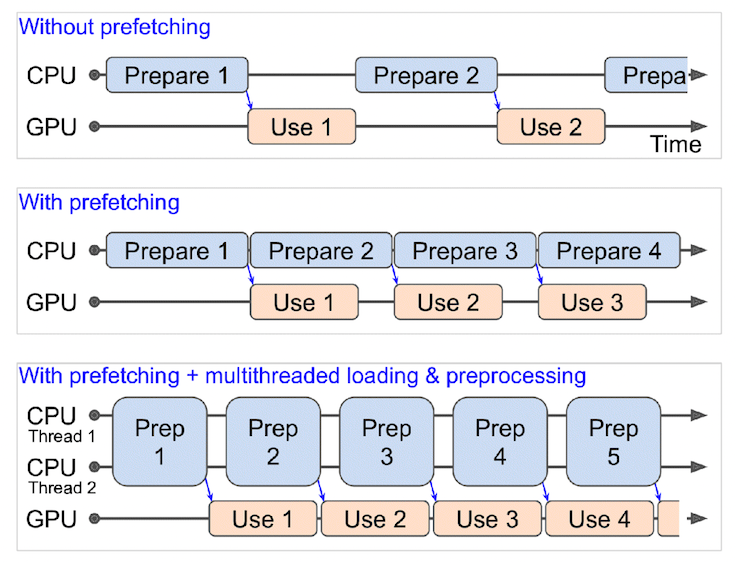!

### * Below code turns on mixed precision training which will speed up training by almost 3 times
### * I am not implementing it, Since it requires GPU compute capabality of 7 or higher
### * If you have such GPU than you can uncomment the below codes for mixed precision.

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

###  Setting mixed precision codes

In [ ]:
## from tensorflow.keras import mixed_precision
## mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
## let's apply performnace optimization function to our dataset:

train_ds = optimize_performance(train_ds)
test_ds = optimize_performance(test_ds)

In [ ]:
## let's visualize some images:

image_batch, label_batch = next(iter(train_ds)) 

plt.figure(figsize=(12,8))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label] + " : "+common_names_list[label])
    plt.axis("off")

In [ ]:
## Our Data is ready.....

In [ ]:
## let's start Model Building:

## <span style= "color:purple;">Part 3: Model Building and Training.</span>

In [ ]:
## imports:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,Flatten,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
## using InceptionV3 as our pretrained model:

base_model = tf.keras.applications.InceptionV3(include_top=False)

In [ ]:
base_model.trainable = False      ## since it is pre-trained setting trainable as False

In [ ]:
# Setup data augmentation:

data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
## Building a Base-Model using Functional api:

inputs = layers.Input(shape = (180,180,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training = False)
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model = tf.keras.Model(inputs,outputs)

In [ ]:
model.summary()

In [ ]:
## creating checkpoint:

checkpoint_path = "checkpoint_weight/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose = 1)

In [ ]:
## compiling our base model:
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds,epochs=5,validation_data=test_ds,callbacks=checkpoint_callback)

In [ ]:
## let's plot loss curves:

def plot_loss_curves(history):
    
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    ## plotting loss:
    
    plt.plot(epochs,loss,label = "training loss")
    plt.plot(epochs,val_loss, label = "val loss")
    plt.title("loss_curve")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    
    ## plotting for accuracy:
    
    plt.figure()
    plt.plot(epochs,accuracy, label = "training accuracy")
    plt.plot(epochs,val_accuracy, label = "val accuracy")
    plt.title("Accuracy_curve")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()

In [ ]:
plot_loss_curves(history=history)

In [ ]:
## let's tune our base model and try to further improve our score:

In [ ]:
## unfreeze all layers:

base_model.trainable = True

## freeze all layers except last 5

for layer in base_model.layers[:-5]:
    layer.trainable = False

In [ ]:
## recompiling model with slower learning rate because we don't want to change weights by much:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
              ,loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
tuned_history = model.fit(train_ds,epochs = 10,validation_data=test_ds,initial_epoch=history.epoch[-1])

In [ ]:
## let's plot untuned and tuned curves together:

def compare_histories(old_history,new_history,initial_epochs=5):
    
    ## un-tuned history data:
    accuracy = old_history.history["accuracy"]
    loss = old_history.history["loss"]
    
    val_accuracy = old_history.history["val_accuracy"]
    val_loss = old_history.history["val_loss"]
    
    ## tuned-history data:
    total_accuracy = accuracy + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    
    total_val_accuracy = val_accuracy + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    
    ## Make plots:
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_accuracy, label = "training accuracy")
    plt.plot(total_val_accuracy, label = "validation accuracy")
    plt.title("Training and Validation Accuracy Curve")
    #plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.axvline(initial_epochs-1,color = "green", ls = "--",label = "start of tuning")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(total_loss, label = "training loss")
    plt.plot(total_val_loss, label = "validation loss")
    plt.title("Training and Validation Loss Curves")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.axvline(initial_epochs-1,color = "green", ls = "--",label = "start of tuning")
    plt.legend()

In [ ]:
compare_histories(old_history=history,new_history=tuned_history,initial_epochs=5)

## <span style= "color:purple;">Part 4: Performance Evaluation.</span>

### * Remember we haven't given any images  from val_dir
### * let's use it to evaluate our model's prediction capabilities.

In [ ]:
## prepapring our validation for our trained model to predict on it:

validation_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                label_mode="categorical",
                                                                image_size=(180,180),
                                                                shuffle=False) 

In [ ]:
## making predictions:

pred_probs = model.predict(validation_data,verbose=1)

In [ ]:
len(pred_probs)

In [ ]:
pred_probs.shape

In [ ]:
pred_probs[31].max()

In [ ]:
pred_classes = pred_probs.argmax(axis=1)

In [ ]:
pred_classes[:5]

In [ ]:
y_labels = []
for image, label in validation_data.unbatch():
    y_labels.append(label.numpy().argmax())
y_labels[:7]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

In [ ]:
## function for preparing image to be predicted:

def load_prepare_image(file_name,scale=True):
    
    img = tf.io.read_file(file_name)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img,[180,180])
    
    if scale:
        return img/255.
    else:
        return img

In [ ]:
class_name = random.choice(class_names)
class_name

In [ ]:
## plot and predict:

plt.figure(figsize=(14,8))
for i in range(2):
    class_name = random.choice(class_names)
    file_name = random.choice(os.listdir(val_dir + "/" + class_name))
    file_path = val_dir + class_name + "/" + file_name
    
    img = load_prepare_image(file_path,scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()]
    pred_class_c_n = common_names_list[pred_prob.argmax()]
    
    ## plot images:
    
    plt.subplot(1,2,i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual : {class_name}, pred: {pred_class}, prob: {pred_prob.max()*100:.2f}%",c = title_color,fontsize=16)
    plt.axis(False);

In [ ]:
## let's see classification report:
from sklearn.metrics import classification_report
print(classification_report(y_labels,pred_classes))

In [ ]:
## let's get dictionary for this classification report:
classification_report_dict = classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

In [ ]:
## let's get f-1 score for all classes with actual classnames:
f1_scores = {}

for k,v in classification_report_dict.items():
    if k == "accuracy":
        break
    else:
        f1_scores[class_names[int(k)]] = v["f1-score"]

f1_scores

In [ ]:
## create dataframe for f1_scores for visualization:

f1_scores_df = pd.DataFrame({"class_name" : list(f1_scores.keys()),
                             "common_name" : common_names_list,
                             "f1_score" : list(f1_scores.values())}).sort_values("f1_score",ascending=False)
                            
    
f1_scores_df

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(x = f1_scores_df["common_name"], y = f1_scores_df["f1_score"])
plt.xlabel("Class names",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(fontsize = 14, rotation = 90)
for index,data in enumerate(f1_scores_df.f1_score):
  plt.text(x=index - 0.25,y=data+0.01,s=f"{data*100:.2f}%",fontsize = 14)
for index,data in enumerate(f1_scores_df.class_name):
  plt.text(x=index - 0.20,y=0.05,s=f"{data}",fontsize = 18)
plt.xticks(fontsize=12)
plt.title("f-1 Score by Class",fontsize=18,pad=30);


In [ ]:
## we have performed so many steps to get this bar plots
## Because not everytime we get a well performing model as ours
## This type of charts can help us see where our model is lagging in predicting and in which class.

In [ ]:
## predicting some random images from internet:

## patas monkey

!wget -q https://animalia.us-east-1.linodeobjects.com/animals/photos/full/1.25x1/macaque-showing-a-bit-of-tongue.jpg
    
img = load_prepare_image("macaque-showing-a-bit-of-tongue.jpg",scale = False)
pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
pred_class = class_names[pred_prob.argmax()]
pred_class_c_n = common_names_list[pred_prob.argmax()]
print(pred_class,pred_class_c_n)

## you can check for others and can playaround with this

## Notebook concludes..

## Upvote it, If you found it to be helpful

## Suggestions and Questions are welcome 

## THANKS...